# How to train your DragoNN tutorial 4: 
## Interpreting predictive sequence features in in-vivo TF binding events

This tutorial is a supplement to the DragoNN manuscript and follows figure 8 in the manuscript. 

This tutorial will take 2 - 3 hours if executed on a GPU.

## Outline<a name='outline'>
<ol>
    <li><a href=#1>Input data</a></li>
    <li><a href=#2>Generating positive and negative bins for genome-wide training </a></li>
    <li><a href=#3>Challenges of in vivo data : batch generators and class upsampling </a></li>
    <li><a href=#3.5>Optional: Download pre-generated models and test-set predictions </a></li>
    <li><a href=#4>Case 1: Negatives consist of shuffled references, single-tasked models</a></li>  
    <li><a href=#5>Case 2: Whole-genome negatives, single-tasked models </a></li>
    <li><a href=#6>Case 3: Whole-genome negatives, multi-tasked models </a></li>
    <li><a href=#7>Case 4: What happens if we don't upsample positive examples in our batches? </a></li>
    <li><a href=#8>Genome-wide interpretation of true positive predictions in SPI1, with DeepLIFT </a></li>
    <li><a href=#9>Conclusions</a></li>    
    <li><a href=#10>Save tutorial outputs</a></li>
</ol>
Github issues on the [dragonn repository](https://github.com/kundajelab/dragonn) with feedback, questions, and discussion are always welcome.


In [141]:
#uncomment the lines below if you are running this tutorial from Google Colab 
#!pip install https://github.com/kundajelab/simdna/archive/0.3.zip
#!pip install https://github.com/kundajelab/dragonn/archive/keras_2.2_tensorflow_1.6_purekeras.zip

In [2]:
# Making sure our results are reproducible
from numpy.random import seed
seed(1234)
from tensorflow import set_random_seed
set_random_seed(1234)

/users/annashch/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/users/annashch/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
#load dragonn tutorial utilities 
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


from dragonn.tutorial_utils import *

Using TensorFlow backend.
/users/annashch/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Input data <a name='1'>
<a href=#outline>Home</a>

Tutorials 1 - 3 have used simulated data generated with the simdna package. In this tutorial, we will examine how well CNN's are able to predict transcription factor binding for four TF's in vivo. 

We will learn to predict transcription factor binding for four transcription factors in the GM12878 cell line (one of the Tier 1 cell lines for the ENCODE project). First, we download the narrowPeak bed files for each of these transcription factors. You can skip the following code block if you already have the data downloaded. 

In [4]:
## CTCF, optimal IDR thresholded peaks, Stam Lab, hg19
# https://www.encodeproject.org/experiments/ENCSR000DRZ/
#!wget https://www.encodeproject.org/files/ENCFF473RXY/@@download/ENCFF473RXY.bed.gz 

## SPI1, optimal IDR thresholded peaks, Myers lab, hg19
# https://www.encodeproject.org/experiments/ENCSR000BGQ/
#!wget https://www.encodeproject.org/files/ENCFF002CHQ/@@download/ENCFF002CHQ.bed.gz
    
## ZNF143, optimal IDR thresholded peaks, Snyder lab, hg19
#https://www.encodeproject.org/experiments/ENCSR936XTK/
#!wget https://www.encodeproject.org/files/ENCFF544NXC/@@download/ENCFF544NXC.bed.gz

## SIX5, optimal IDR thresholded peaks, Myers Lab, hg19
# https://www.encodeproject.org/experiments/ENCSR000BJE/
#!wget https://www.encodeproject.org/files/ENCFF606WUV/@@download/ENCFF606WUV.bed.gz

## Download the hg19 chromsizes file (We only use chroms 1 -22, X, Y for training)
#!wget https://github.com/kundajelab/dragonn/blob/keras_2.2_tensorflow_1.6_purekeras/paper_supplement/hg19.chrom.sizes
    
## Download the hg19 fasta reference genome (and corresponding .fai index)
#!wget http://mitra.stanford.edu/kundaje/projects/dragonn/hg19.genome.fa.gz
#!wget http://mitra.stanford.edu/kundaje/projects/dragonn/hg19.genome.fa.fai 


## Generating positive and negative bins for genome-wide training <a name='2'>
<a href=#outline>Home</a>

We will use the *genomewide_labels* function from the  [seqdataloader](https://github.com/kundajelab/seqdataloader) package to generate positive and negative labels for the TF-ChIPseq peaks across the genome. We will treat each sample as a task for the model and compare the performance of the model on SPI1 task in the single-tasked and multi-tasked setting.

In [5]:
from seqdataloader import * 

In [6]:
## seqdataloader accepts an input file, which we call tasks.tsv, with task names in column 1 and the corresponding
## peak files in column 2 
!cat tasks.tsv 

SPI1	ENCFF002CHQ.bed.gz	
CTCF	ENCFF473RXY.bed.gz	
ZNF143	ENCFF544NXC.bed.gz	
SIX5	ENCFF606WUV.bed.gz	


With the parameter configuration below, seqdataloader splits the genome into 1kb regions, with a stride of 50. Each 1kb region is centered at a 200 bp bin, with a left flank of 400 bases and a right flank of 400 bases. 

* Each 200 bp bin is labeled as positive if a narrowPeak summit overlaps with it. 

* The bin is labeled ambiguous (label = -1) and excluded from training if there is some overlap with the narrowPeak, but the peak summit does not lie in that overlap. 

* The bin is labeled negative if there is no overlap with the narrowPeak. 

In [ ]:
#we will include all chromosomes with the exception of 1,2, and 19 in our training set 

#1) Generate genome-wide negatives in addition to positives 
train_set_params={
    'task_list':"tasks.tsv",
    'outf':"TF.train.hdf5",
    'output_type':'hdf5',
    'chrom_sizes':'hg19.chrom.sizes',
    'chroms_to_exclude':['chr1','chr2','chr19'],
    'bin_stride':50,
    'left_flank':400,
    'right_flank':400,
    'bin_size':200,
    'threads':4,
    'subthreads':4,
    'allow_ambiguous':False,
    'labeling_approach':'peak_summit_in_bin_classification'
    }
genomewide_labels(train_set_params)

#2) Extract positive bins for each task for DeepBind training paradigm -- shuffled reference negatives to be 
#generated on the fly 

positives_train_set_params={
    'store_positives_only':True,
    'task_list':"tasks.tsv",
    'outf':"positives.TF.train.hdf5",
    'output_type':'hdf5',
    'chrom_sizes':'hg19.chrom.sizes',
    'chroms_to_exclude':['chr1','chr2','chr19'],
    'bin_stride':50,
    'left_flank':400,
    'right_flank':400,
    'bin_size':200,
    'threads':4,
    'subthreads':4,
    'allow_ambiguous':False,
    'labeling_approach':'peak_summit_in_bin_classification'
    }
genomewide_labels(positives_train_set_params)

In [ ]:
#We will include chromsome 1 in our validation set 

#1) Generate genome-wide negatives in addition to positives 
valid_set_params={'task_list':"tasks.tsv",
    'outf':"TF.valid.hdf5",
    'output_type':'hdf5',
    'chrom_sizes':'hg19.chrom.sizes',
    'chroms_to_keep':'chr1',
    'bin_stride':50,
    'left_flank':400,
    'right_flank':400,
    'bin_size':200,
    'threads':1,
    'subthreads':4,
    'allow_ambiguous':False,
    'labeling_approach':'peak_summit_in_bin_classification'
    }
genomewide_labels(valid_set_params)


#2) Extract positive bins for each task for DeepBind training paradigm -- shuffled reference negatives to be 
#generated on the fly 
positives_valid_set_params={
    'store_positives_only':True,
    'task_list':"tasks.tsv",
    'outf':"positives.TF.valid.hdf5",
    'output_type':'hdf5',
    'chrom_sizes':'hg19.chrom.sizes',
    'chroms_to_keep':'chr1',
    'bin_stride':50,
    'left_flank':400,
    'right_flank':400,
    'bin_size':200,
    'threads':1,
    'subthreads':4,
    'allow_ambiguous':False,
    'labeling_approach':'peak_summit_in_bin_classification'
    }
genomewide_labels(positives_valid_set_params)


In [ ]:
#We will include chromosomes 2 and 19 in our testing set 
test_set_params={
    'task_list':"tasks.tsv",
    'outf':"TF.test.hdf5",
    'output_type':'hdf5',
    'chrom_sizes':'hg19.chrom.sizes',
    'chroms_to_keep':['chr2','chr19'],
    'bin_stride':50,
    'left_flank':400,
    'right_flank':400,
    'bin_size':200,
    'threads':2,
    'subthreads':4,
    'allow_ambiguous':False,
    'labeling_approach':'peak_summit_in_bin_classification'
    }
genomewide_labels(test_set_params)

#2) Extract positive bins for each task for DeepBind training paradigm -- shuffled reference negatives to be 
#generated on the fly 
positives_test_set_params={
    'store_positives_only':True,
    'task_list':"tasks.tsv",
    'outf':"positives.TF.test.hdf5",
    'output_type':'hdf5',
    'chrom_sizes':'hg19.chrom.sizes',
    'chroms_to_keep':['chr2','chr19'],
    'bin_stride':50,
    'left_flank':400,
    'right_flank':400,
    'bin_size':200,
    'threads':2,
    'subthreads':4,
    'allow_ambiguous':False,
    'labeling_approach':'peak_summit_in_bin_classification'
    }
genomewide_labels(positives_test_set_params)


Let's examine the files that were generated: 

In [7]:
#The code generates bed file outputs with a label of 1 or 0 for each 1kb
# genome bin for each task. Note that the bins are shifted with a stride of 50.
pd.read_hdf("TF.train.hdf5",start=0,stop=10)

SPI1  CTCF  ZNF143  SIX5
CHR  START END                           
chr3 0     1000   0.0   0.0     0.0   0.0
     50    1050   0.0   0.0     0.0   0.0
     100   1100   0.0   0.0     0.0   0.0
     150   1150   0.0   0.0     0.0   0.0
     200   1200   0.0   0.0     0.0   0.0
     250   1250   0.0   0.0     0.0   0.0
     300   1300   0.0   0.0     0.0   0.0
     350   1350   0.0   0.0     0.0   0.0
     400   1400   0.0   0.0     0.0   0.0
     450   1450   0.0   0.0     0.0   0.0

In [8]:
# When provided with the --store-positives_only flag, the code generates all bins for each task that are labeled positive.
pd.read_hdf("SPI1.positives.TF.train.hdf5",start=0,stop=10)

SPI1
CHR  START  END         
chr3 260350 261350   1.0
     260400 261400   1.0
     260450 261450   1.0
     260500 261500   1.0
     319150 320150   1.0
     319200 320200   1.0
     319250 320250   1.0
     319300 320300   1.0
     320050 321050   1.0
     320100 321100   1.0

In [9]:
#We load our test set labels into memory here, as we will use them to measure performance in cases 1 - 4 below.
#Note that we only load the labels into memory, not the actual test dataset. 

#It is not necessary to load the training/validation dataset or labels, see below. 
test_set=pd.read_hdf("TF.test.hdf5")
test_set

SPI1  CTCF  ZNF143  SIX5
CHR   START    END                               
chr2  0        1000       0.0   0.0     0.0   0.0
      50       1050       0.0   0.0     0.0   0.0
      100      1100       0.0   0.0     0.0   0.0
      150      1150       0.0   0.0     0.0   0.0
      200      1200       0.0   0.0     0.0   0.0
      250      1250       0.0   0.0     0.0   0.0
      300      1300       0.0   0.0     0.0   0.0
      350      1350       0.0   0.0     0.0   0.0
      400      1400       0.0   0.0     0.0   0.0
      450      1450       0.0   0.0     0.0   0.0
      500      1500       0.0   0.0     0.0   0.0
      550      1550       0.0   0.0     0.0   0.0
      600      1600       0.0   0.0     0.0   0.0
      650      1650       0.0   0.0     0.0   0.0
      700      1700       0.0   0.0     0.0   0.0
      750      1750       0.0   0.0     0.0   0.0
      800      1800       0.0   0.0     0.0   0.0
      850      1850       0.0   0.0     0.0   0.0
      900      1900       0.0   0.0     0.0   0.0
      950      1950       0.0   0.0     0.0   0.0
      1000     2000       0.0   0.0     0.0   0.0
      1050     2050       0.0   0.0     0.0   0.0
      1100     2100       0.0   0.0     0.0   0.0
      1150     2150       0.0   0.0     0.0   0.0
      1200     2200       0.0   0.0     0.0   0.0
      1250     2250       0.0   0.0     0.0   0.0
      1300     2300       0.0   0.0     0.0   0.0
      1350     2350       0.0   0.0     0.0   0.0
      1400     2400       0.0   0.0     0.0   0.0
      1450     2450       0.0   0.0     0.0   0.0
...                       ...   ...     ...   ...
chr19 59126500 59127500   0.0   0.0     0.0   0.0
      59126550 59127550   0.0   0.0     0.0   0.0
      59126600 59127600   0.0   0.0     0.0   0.0
      59126650 59127650   0.0   0.0     0.0   0.0
      59126700 59127700   0.0   0.0     0.0   0.0
      59126750 59127750   0.0   0.0     0.0   0.0
      59126800 59127800   0.0   0.0     0.0   0.0
      59126850 59127850   0.0   0.0     0.0   0.0
      59126900 59127900   0.0   0.0     0.0   0.0
      59126950 59127950   0.0   0.0     0.0   0.0
      59127000 59128000   0.0   0.0     0.0   0.0
      59127050 59128050   0.0   0.0     0.0   0.0
      59127100 59128100   0.0   0.0     0.0   0.0
      59127150 59128150   0.0   0.0     0.0   0.0
      59127200 59128200   0.0   0.0     0.0   0.0
      59127250 59128250   0.0   0.0     0.0   0.0
      59127300 59128300   0.0   0.0     0.0   0.0
      59127350 59128350   0.0   0.0     0.0   0.0
      59127400 59128400   0.0   0.0     0.0   0.0
      59127450 59128450   0.0   0.0     0.0   0.0
      59127500 59128500   0.0   0.0     0.0   0.0
      59127550 59128550   0.0   0.0     0.0   0.0
      59127600 59128600   0.0   0.0     0.0   0.0
      59127650 59128650   0.0   0.0     0.0   0.0
      59127700 59128700   0.0   0.0     0.0   0.0
      59127750 59128750   0.0   0.0     0.0   0.0
      59127800 59128800   0.0   0.0     0.0   0.0
      59127850 59128850   0.0   0.0     0.0   0.0
      59127900 59128900   0.0   0.0     0.0   0.0
      59127950 59128950   0.0   0.0     0.0   0.0

[6046528 rows x 4 columns]

## Challenges of in vivo data : batch generators and class upsampling <a name='3'>
<a href=#outline>Home</a>

In tutorials 1 - 3, we used the [keras fit](https://keras.io/models/sequential/#fit) function to train a CNN. However, when working with real data we face two new challenges: 

1) The dataset is much bigger. In our training set, there are 50,881,560 1kb bins, in our validation set, there are 4,984,994 bins, and in our test set there are 6,046,529 bins. Loading this dataset into memory to pass as a numpy array to the CNN code will require more memory than is available on many machines. Consequently, we use the [keras fit_generator](https://keras.io/models/sequential/#fit_generator) function to limit the memory footprint. This function reads in one batch of training and one batch of validation data at a time from a python generator. in *dragonn.generators*, we provide several python generator functions to match the scenarios below. 

In [10]:
from dragonn.generators import * 

2) The dataset is highly imbalanced. Of the 50,881,560 1kb bins in the training set, only 

* 136,279 are labeled positive for the SPI1 task (372 negatives: 1 positive )

* 131,245 are labeled positive for the CTCF task (387 negatives: 1 positive ) 

* 93,981 are labeled positive for the ZNF143 task (540 negatives: 1 positive ) 

* 15,641 are labeled positive for the SIX5 task (3252 negatives: 1 positive ) 

The class imbalance is far too high for the model to learn unassisted. Hence, we upsample the positive bins to include in each batch with the "upsample" argument to DataGenerator. The upsample argument accepts a fraction between 0 and 1 and ensures that this fraction of the batch consists of positive bins. 


In [11]:
#To prepare for model training, we import the necessary functions and submodules from keras
from keras.models import Sequential
from keras.layers.core import Dropout, Reshape, Dense, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adadelta, SGD, RMSprop;
import keras.losses;
from keras.constraints import maxnorm;
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping, History
from keras import backend as K 
K.set_image_data_format('channels_last')

In [12]:
from concise.metrics import tpr, tnr, fpr, fnr, precision, f1
def initialize_model(ntasks=1):
    #Define the model architecture in keras (regularized, 3-layer convolution model followed by 1 dense layer)
    model=Sequential() 
    
    model.add(Conv2D(filters=15,kernel_size=(1,10),input_shape=(1,1000,4)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size=(1,35)))

    model.add(Conv2D(filters=15,kernel_size=(1,10)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=15,kernel_size=(1,10)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(ntasks))
    model.add(Activation("sigmoid"))

    ##compile the model, specifying the Adam optimizer, and binary cross-entropy loss. 
    model.compile(optimizer='adam',loss='binary_crossentropy',
                  metrics=[tpr,
                           tnr,
                           fpr,
                           fnr,
                           precision,
                           f1])
    return model

### Download pre-generated models and test set predictions (optional) <a name='3.5'>
<a href=#outline>Home</a>

#### **Note: on a GPU, each of the models below should take 10 - 15 minutes to train, with an additional 7-10 minutesu for prediction on the corresponding test sets. Although training the models is a valuable exercise, for the sake of time, we also provide hdf5 files with pre-trained models and test set predictions. These were generated by running the tutorial and saving the outputs at the end (see <a href=#10>Save tutorial outputs</a>). Uncomment the cell below if you wish to load the pre-trained models and test set predictions to use for performance comparison and DeepLIFT analyis** 

In [159]:
#Download the models 
#!wget http://mitra.stanford.edu/kundaje/projects/dragonn/case1_spi1_model.hdf5
#!wget http://mitra.stanford.edu/kundaje/projects/dragonn/case1_ctcf_model.hdf5
#!wget http://mitra.stanford.edu/kundaje/projects/dragonn/case2_spi1_model.hdf5
#!wget http://mitra.stanford.edu/kundaje/projects/dragonn/case2_ctcf_model.hdf5
#!wget http://mitra.stanford.edu/kundaje/projects/dragonn/case3_model.hdf5
#!wget http://mitra.stanford.edu/kundaje/projects/dragonn/case4_spi1_model.hdf5
    


In [160]:
#Load the models from hdf5 
#from keras.models import load_model 
#case1_spi1_model=load_model("case1_spi1_model.hdf5")
#case1_ctcf_model=load_model("case1_ctcf_model.hdf5")
#case2_spi1_model=load_model("case2_spi1_model.hdf5")
#case2_ctcf_model=load_model("case2_ctcf_model.hdf5")
#case3_model=load_model("case3_model.hdf5")
#case4_spi1_model=load_model("case4_spi1_model.hdf5")


In [ ]:

#Download test set predictions 
#!wget http://mitra.stanford.edu/kundaje/projects/dragonn/test_set_predictions.hdf5


In [161]:
#Extract predictions from hdf5 for each model 
#import h5py
#test_set_predictions=h5py.File("test_set_predictions.hdf5")


In [162]:
#case1_spi1_test_predictions=test_set_predictions["case1_spi1_test_predictions"].value
#case1_ctcf_test_predictions=test_set_predictions["case1_spi1_test_predictions"].value
#case2_spi1_test_predictions=test_set_predictions["case2_spi1_test_predictions"].value
#case2_ctcf_test_predictions=test_set_predictions["case2_ctcf_test_predictions"].value
#case3_test_predictions=test_set_predictions["case3_test_predictions"].value
#case4_spi1_test_predictions=test_set_predictions["case4_spi1_test_predictions"].value

In [163]:
#case1_spi1_test_predictions.shape

(6046000, 1)

## Case 1: Negatives consist of shuffled references, single-tasked models<a name='4'>
<a href=#outline>Home</a>

We begin by training a model on the SPI1 and CTCF dataset with the following specifications: 

* We use dinucleotide-shuffled positive bins as the negative set. 

* Each batch contains one-hot encoded 1kb regions from the genome, as well as the one-hot-encoded reverse complement sequences of those regions. 

* We ensure that at least 10% of the samples in each batch are positives 



In [ ]:
We create generators for the training and validation data to meet these specifications: 

In [32]:
#create the generators
from dragonn.generators import * 
case1_spi1_train_gen=DataGenerator("SPI1.positives.TF.train.hdf5","hg19.genome.fa.gz",shuffled_ref_negatives=True,upsample=False)
case1_spi1_valid_gen=DataGenerator("SPI1.positives.TF.valid.hdf5","hg19.genome.fa.gz",shuffled_ref_negatives=True,upsample=False)
case1_ctcf_train_gen=DataGenerator("CTCF.positives.TF.train.hdf5","hg19.genome.fa.gz",shuffled_ref_negatives=True,upsample=False)
case1_ctcf_valid_gen=DataGenerator("CTCF.positives.TF.valid.hdf5","hg19.genome.fa.gz",shuffled_ref_negatives=True,upsample=False)

We now follow the standard protocol we used in tutorials 1 - 3 to train a keras model, with the exception that we use the fit_generator function in keras, rather than the fit function.

In [33]:
#Train the SPI1 model 
case1_spi1_model=initialize_model()

## use the keras fit_generator function to train the model with early stopping after 3 epochs 
history_case1_spi1=case1_spi1_model.fit_generator(case1_spi1_train_gen,
                                                  validation_data=case1_spi1_valid_gen,
                                                  steps_per_epoch=1000,
                                                  validation_steps=1000,
                                                  epochs=150,
                                                  verbose=1,
                                                  use_multiprocessing=True,
                                                  workers=40,
                                                  max_queue_size=100,
                                                  callbacks=[EarlyStopping(patience=3,restore_best_weights=True),History()])

Epoch 1/150
1000/1000 [==============================] - 46s 46ms/step - loss: 0.2828 - sensitivity: 0.8520 - specificity: 0.8929 - fpr: 0.1071 - fnr: 0.1480 - precision: 0.8936 - f1: 0.8633 - val_loss: 0.1399 - val_sensitivity: 0.9315 - val_specificity: 0.9755 - val_fpr: 0.0245 - val_fnr: 0.0685 - val_precision: 0.9750 - val_f1: 0.9514
Epoch 2/150
1000/1000 [==============================] - 36s 36ms/step - loss: 0.1381 - sensitivity: 0.9368 - specificity: 0.9571 - fpr: 0.0429 - fnr: 0.0632 - precision: 0.9593 - f1: 0.9450 - val_loss: 0.0865 - val_sensitivity: 0.9545 - val_specificity: 0.9775 - val_fpr: 0.0225 - val_fnr: 0.0455 - val_precision: 0.9774 - val_f1: 0.9654
Epoch 3/150
1000/1000 [==============================] - 38s 38ms/step - loss: 0.1133 - sensitivity: 0.9500 - specificity: 0.9635 - fpr: 0.0365 - fnr: 0.0500 - precision: 0.9657 - f1: 0.9554 - val_loss: 0.1822 - val_sensitivity: 0.8502 - val_specificity: 0.9994 - val_fpr: 6.0937e-04 - val_fnr: 0.1498 - val_precision: 0.9

In [34]:
#Train the CTCF model 
case1_ctcf_model=initialize_model()

## use the keras fit_generator function to train the model with early stopping after 3 epochs 
history_case1_ctcf=case1_ctcf_model.fit_generator(case1_ctcf_train_gen,
                                                  validation_data=case1_ctcf_valid_gen,
                                                  steps_per_epoch=1000,
                                                  validation_steps=1000,
                                                  epochs=150,
                                                  verbose=1,
                                                  use_multiprocessing=True,
                                                  workers=40,
                                                  max_queue_size=100,
                                                  callbacks=[EarlyStopping(patience=3,restore_best_weights=True),History()])

Epoch 1/150
1000/1000 [==============================] - 55s 55ms/step - loss: 0.3254 - sensitivity: 0.8186 - specificity: 0.8547 - fpr: 0.1453 - fnr: 0.1814 - precision: 0.8554 - f1: 0.8260 - val_loss: 0.2350 - val_sensitivity: 0.7953 - val_specificity: 0.9975 - val_fpr: 0.0025 - val_fnr: 0.2047 - val_precision: 0.9970 - val_f1: 0.8804
Epoch 2/150
1000/1000 [==============================] - 37s 37ms/step - loss: 0.1226 - sensitivity: 0.9476 - specificity: 0.9586 - fpr: 0.0414 - fnr: 0.0524 - precision: 0.9607 - f1: 0.9518 - val_loss: 0.0696 - val_sensitivity: 0.9646 - val_specificity: 0.9891 - val_fpr: 0.0109 - val_fnr: 0.0354 - val_precision: 0.9890 - val_f1: 0.9764
Epoch 3/150
1000/1000 [==============================] - 37s 37ms/step - loss: 0.0874 - sensitivity: 0.9633 - specificity: 0.9715 - fpr: 0.0285 - fnr: 0.0367 - precision: 0.9729 - f1: 0.9667 - val_loss: 0.0502 - val_sensitivity: 0.9717 - val_specificity: 0.9924 - val_fpr: 0.0076 - val_fnr: 0.0283 - val_precision: 0.9924 

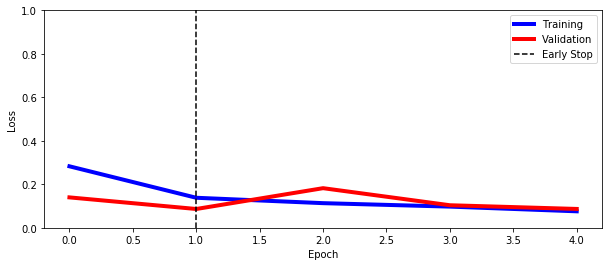

In [35]:
## Plot the learning curves for SPI1  
from dragonn.tutorial_utils import plot_learning_curve
plot_learning_curve(history_case1_spi1)

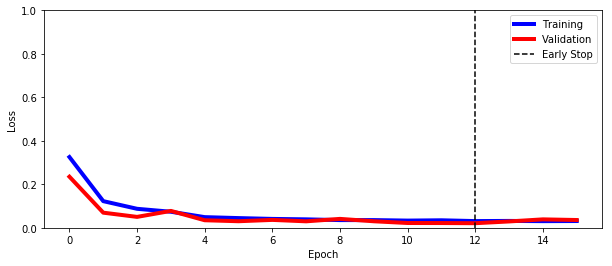

In [36]:
## Plot the learning curve for CTCF 
plot_learning_curve(history_case1_ctcf)

We now measure how well the models performed by calculating performance metrics on the test splits across the whole genome. 

In [37]:
case1_spi1_test_gen=DataGenerator("TF.test.hdf5",
                                   "hg19.genome.fa.gz",
                                     upsample=False,
                                     add_revcomp=False,
                                     batch_size=1000,
                                     tasks=['SPI1'])
case1_spi1_test_predictions=case1_spi1_model.predict_generator(case1_spi1_test_gen,
                                                               max_queue_size=5000, 
                                                               workers=40, 
                                                               use_multiprocessing=True, 
                                                               verbose=1)


6046/6046 [==============================] - 345s 57ms/step


In [38]:
case1_ctcf_test_gen=DataGenerator("TF.test.hdf5",
                                   "hg19.genome.fa.gz",
                                     upsample=False,
                                     add_revcomp=False,
                                     batch_size=1000,
                                     tasks=['CTCF'])
case1_ctcf_test_predictions=case1_ctcf_model.predict_generator(case1_ctcf_test_gen,max_queue_size=5000, workers=40, use_multiprocessing=True, verbose=1)


6046/6046 [==============================] - 338s 56ms/step


In [39]:
#format true & predicted test labels for performance assessment 

#if test_set.shape is not a multiple of batch_size, 
#there may be some extra values in test_set that need to get truncated.
spi1_test_truth=np.expand_dims(test_set['SPI1'][0:case1_spi1_test_predictions.shape[0]],1).astype(bool)

In [40]:
## Generate a ClassificationResult object to print performance metrics on held-out test set 
from dragonn.metrics import ClassificationResult
print(ClassificationResult(spi1_test_truth,case1_spi1_test_predictions))

Loss: inf	Balanced Accuracy: 50.48%	 auROC: 0.542	 auPRC: 0.004
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 20189	 Num Negatives: 6025811


In [41]:
ctcf_test_truth=np.expand_dims(test_set['CTCF'][0:case1_ctcf_test_predictions.shape[0]],1).astype(bool)

In [42]:
## Generate a ClassificationResult object to print performance metrics on held-out test set 
print(ClassificationResult(ctcf_test_truth,case1_ctcf_test_predictions))

Loss: nan	Balanced Accuracy: 49.96%	 auROC: 0.521	 auPRC: 0.056
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 19611	 Num Negatives: 6026389


## Case 2: Whole-genome negatives, single-tasked models <a name='5'>
<a href=#outline>Home</a>

In [ ]:
#create the generators
from dragonn.generators import * 
case2_spi1_train_gen=DataGenerator("TF.train.hdf5","hg19.genome.fa.gz",tasks=["SPI1"],upsample_ratio=0.3)
case2_spi1_valid_gen=DataGenerator("TF.valid.hdf5","hg19.genome.fa.gz",tasks=["SPI1"],upsample_ratio=0.3)
case2_ctcf_train_gen=DataGenerator("TF.train.hdf5","hg19.genome.fa.gz",tasks=["CTCF"],upsample_ratio=0.3)
case2_ctcf_valid_gen=DataGenerator("TF.valid.hdf5","hg19.genome.fa.gz",tasks=["CTCF"],upsample_ratio=0.3)


In [25]:
#Train the SPI1 model 
case2_spi1_model=initialize_model()

## use the keras fit_generator function to train the model with early stopping after 3 epochs 
history_case2_spi1=case2_spi1_model.fit_generator(case2_spi1_train_gen,
                                                  validation_data=case2_spi1_valid_gen,
                                                  steps_per_epoch=10000,
                                                  validation_steps=10000,
                                                  epochs=150,
                                                  verbose=1,
                                                  use_multiprocessing=True,
                                                  workers=40,
                                                  max_queue_size=100,
                                                  callbacks=[EarlyStopping(patience=3,restore_best_weights=True),History()])

Epoch 1/150
10000/10000 [==============================] - 199s 20ms/step - loss: 0.3038 - sensitivity: 0.7392 - specificity: 0.9229 - fpr: 0.0771 - fnr: 0.2608 - precision: nan - f1: nan - val_loss: 0.2127 - val_sensitivity: 0.8892 - val_specificity: 0.9260 - val_fpr: 0.0740 - val_fnr: 0.1108 - val_precision: 0.8399 - val_f1: 0.8618
Epoch 2/150
10000/10000 [==============================] - 184s 18ms/step - loss: 0.2293 - sensitivity: 0.8393 - specificity: 0.9355 - fpr: 0.0645 - fnr: 0.1607 - precision: 0.8515 - f1: 0.8423 - val_loss: 0.2028 - val_sensitivity: 0.8663 - val_specificity: 0.9400 - val_fpr: 0.0600 - val_fnr: 0.1337 - val_precision: 0.8631 - val_f1: 0.8625
Epoch 3/150
10000/10000 [==============================] - 182s 18ms/step - loss: 0.2241 - sensitivity: 0.8432 - specificity: 0.9375 - fpr: 0.0625 - fnr: 0.1568 - precision: 0.8558 - f1: 0.8466 - val_loss: 0.2009 - val_sensitivity: 0.8758 - val_specificity: 0.9398 - val_fpr: 0.0602 - val_fnr: 0.1242 - val_precision: 0.86

In [26]:
#Train the CTCF model 
case2_ctcf_model=initialize_model()

## use the keras fit_generator function to train the model with early stopping after 3 epochs 
history_case2_ctcf=case2_ctcf_model.fit_generator(case2_ctcf_train_gen,
                                                  validation_data=case2_ctcf_valid_gen,
                                                  steps_per_epoch=10000,
                                                  validation_steps=10000,
                                                  epochs=150,
                                                  verbose=1,
                                                  use_multiprocessing=True,
                                                  workers=40,
                                                  max_queue_size=100,
                                                  callbacks=[EarlyStopping(patience=3,restore_best_weights=True),History()])

Epoch 1/150
10000/10000 [==============================] - 201s 20ms/step - loss: 0.2856 - sensitivity: 0.7612 - specificity: 0.9284 - fpr: 0.0716 - fnr: 0.2388 - precision: nan - f1: nan - val_loss: 0.2202 - val_sensitivity: 0.8126 - val_specificity: 0.9522 - val_fpr: 0.0478 - val_fnr: 0.1875 - val_precision: 0.8814 - val_f1: 0.8427
Epoch 2/150
10000/10000 [==============================] - 180s 18ms/step - loss: 0.2274 - sensitivity: 0.8288 - specificity: 0.9417 - fpr: 0.0583 - fnr: 0.1712 - precision: 0.8619 - f1: 0.8422 - val_loss: 0.2052 - val_sensitivity: 0.8505 - val_specificity: 0.9459 - val_fpr: 0.0541 - val_fnr: 0.1495 - val_precision: 0.8730 - val_f1: 0.8592
Epoch 3/150
10000/10000 [==============================] - 181s 18ms/step - loss: 0.2204 - sensitivity: 0.8321 - specificity: 0.9450 - fpr: 0.0550 - fnr: 0.1679 - precision: 0.8691 - f1: 0.8474 - val_loss: 0.2047 - val_sensitivity: 0.8295 - val_specificity: 0.9572 - val_fpr: 0.0428 - val_fnr: 0.1705 - val_precision: 0.89

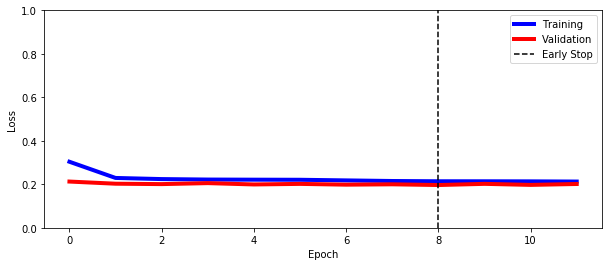

In [27]:
## Plot the learning curves for SPI1  
plot_learning_curve(history_case2_spi1)

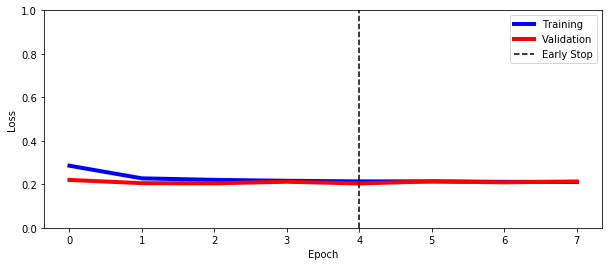

In [28]:
## Plot the learning curves for CTCF  
plot_learning_curve(history_case2_ctcf)

In [29]:
#Get model predictions on the test set 
case2_spi1_test_gen=DataGenerator("TF.test.hdf5",
                                   "hg19.genome.fa.gz",
                                     upsample=False,
                                     add_revcomp=False,
                                     batch_size=1000,
                                     tasks=['SPI1'])
case2_spi1_test_predictions=case2_spi1_model.predict_generator(case2_spi1_test_gen,
                                                               max_queue_size=5000, 
                                                               workers=40, 
                                                               use_multiprocessing=True, 
                                                               verbose=1)


6046/6046 [==============================] - 361s 60ms/step


In [30]:
case2_ctcf_test_gen=DataGenerator("TF.test.hdf5",
                                   "hg19.genome.fa.gz",
                                     upsample=False,
                                     add_revcomp=False,
                                     batch_size=1000,
                                     tasks=['CTCF'])
case2_ctcf_test_predictions=case2_ctcf_model.predict_generator(case2_ctcf_test_gen,max_queue_size=5000, workers=40, use_multiprocessing=True, verbose=1)


6046/6046 [==============================] - 347s 57ms/step


In [43]:
from dragonn.metrics import ClassificationResult
## Generate a ClassificationResult object to print performance metrics on held-out test set 
print(ClassificationResult(spi1_test_truth,case2_spi1_test_predictions))

Loss: 0.1162	Balanced Accuracy: 89.98%	 auROC: 0.975	 auPRC: 0.232
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.3%	 Num Positives: 20189	 Num Negatives: 6025811


In [44]:
## Generate a ClassificationResult object to print performance metrics on held-out test set 
print(ClassificationResult(ctcf_test_truth,case2_ctcf_test_predictions))

Loss: 0.1063	Balanced Accuracy: 88.66%	 auROC: 0.974	 auPRC: 0.388
	Recall at 5%|10%|20% FDR: 0.1%|4.7%|12.8%	 Num Positives: 19611	 Num Negatives: 6026389


## Case 3: Whole-genome negatives, multi-tasked models <a name='6'>
<a href=#outline>Home</a>

In [45]:
#create the generators for multi-tasked models. Guarantee 10% positives in each batch 
case3_train_gen=DataGenerator("TF.train.hdf5","hg19.genome.fa.gz",upsample_ratio=0.3)
case3_valid_gen=DataGenerator("TF.valid.hdf5","hg19.genome.fa.gz",upsample_ratio=0.3)

In [47]:
#Train the SPI1 model 
case3_model=initialize_model(4)

## use the keras fit_generator function to train the model with early stopping after 3 epochs 
history_case3=case3_model.fit_generator(case3_train_gen,
                                        validation_data=case3_valid_gen,
                                        steps_per_epoch=1000,
                                        validation_steps=1000,
                                        epochs=10,
                                        verbose=1,
                                        use_multiprocessing=True,
                                        workers=40,
                                        max_queue_size=100,
                                        callbacks=[EarlyStopping(patience=3,restore_best_weights=True),History()])

Epoch 1/10
1000/1000 [==============================] - 45s 45ms/step - loss: 0.2606 - sensitivity: 0.0328 - specificity: 0.9937 - fpr: 0.0063 - fnr: 0.9672 - precision: nan - f1: nan - val_loss: 0.2536 - val_sensitivity: 0.0211 - val_specificity: 0.9985 - val_fpr: 0.0015 - val_fnr: 0.9789 - val_precision: nan - val_f1: nan
Epoch 2/10
1000/1000 [==============================] - 19s 19ms/step - loss: 0.2360 - sensitivity: 0.0588 - specificity: 0.9959 - fpr: 0.0041 - fnr: 0.9412 - precision: nan - f1: nan - val_loss: 0.2358 - val_sensitivity: 0.0560 - val_specificity: 0.9970 - val_fpr: 0.0030 - val_fnr: 0.9440 - val_precision: nan - val_f1: nan
Epoch 3/10
1000/1000 [==============================] - 18s 18ms/step - loss: 0.2224 - sensitivity: 0.1445 - specificity: 0.9914 - fpr: 0.0086 - fnr: 0.8555 - precision: nan - f1: nan - val_loss: 0.2192 - val_sensitivity: 0.1537 - val_specificity: 0.9929 - val_fpr: 0.0071 - val_fnr: 0.8463 - val_precision: nan - val_f1: nan
Epoch 4/10
1000/1000 [

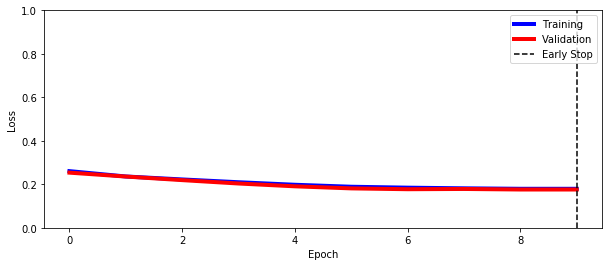

In [48]:
## Plot the learning curves for the multi-tasked model   
plot_learning_curve(history_case3)

In [49]:
case3_test_gen=DataGenerator("TF.test.hdf5",
                             "hg19.genome.fa.gz",
                             upsample=False,
                             add_revcomp=False,
                             batch_size=1000)
case3_test_predictions=case3_model.predict_generator(case3_test_gen,
                                                     max_queue_size=5000, 
                                                     workers=40, 
                                                     use_multiprocessing=True, 
                                                     verbose=1)


6046/6046 [==============================] - 364s 60ms/step


In [69]:
test_truth=test_set[0:case3_test_predictions.shape[0]].astype(bool)

In [75]:
test_truth.columns

Index(['SPI1', 'CTCF', 'ZNF143', 'SIX5'], dtype='object')

In [73]:
## Generate a ClassificationResult object to print performance metrics on held-out test set 
print(ClassificationResult(np.expand_dims(test_truth['SPI1'],1),
                           np.expand_dims(case3_test_predictions[:,0],1)))

Loss: 0.1097	Balanced Accuracy: 67.10%	 auROC: 0.898	 auPRC: 0.047
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 20189	 Num Negatives: 6025811


In [76]:
## Generate a ClassificationResult object to print performance metrics on held-out test set 
print(ClassificationResult(np.expand_dims(test_truth['CTCF'],1),
                           np.expand_dims(case3_test_predictions[:,1],1)))

Loss: 0.0500	Balanced Accuracy: 75.13%	 auROC: 0.961	 auPRC: 0.278
	Recall at 5%|10%|20% FDR: 0.1%|0.3%|4.3%	 Num Positives: 19611	 Num Negatives: 6026389


In [77]:
## Generate a ClassificationResult object to print performance metrics on held-out test set 
print(ClassificationResult(np.expand_dims(test_truth['ZNF143'],1),
                           np.expand_dims(case3_test_predictions[:,2],1)))

Loss: 0.0494	Balanced Accuracy: 59.65%	 auROC: 0.923	 auPRC: 0.078
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 18148	 Num Negatives: 6027852


In [78]:
## Generate a ClassificationResult object to print performance metrics on held-out test set 
print(ClassificationResult(np.expand_dims(test_truth['SIX5'],1),
                           np.expand_dims(case3_test_predictions[:,3],1)))

Loss: 0.0062	Balanced Accuracy: 50.00%	 auROC: 0.947	 auPRC: 0.048
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 3770	 Num Negatives: 6042230


## Case 4: What happens if we don't upsample positive examples in our batches? <a name='7'>
<a href=#outline>Home</a>

In [79]:
#create the generators
case4_spi1_train_gen=DataGenerator("TF.train.hdf5","hg19.genome.fa.gz",tasks=["SPI1"],upsample=False)
case4_spi1_valid_gen=DataGenerator("TF.valid.hdf5","hg19.genome.fa.gz",tasks=["SPI1"],upsample=False)

In [81]:
#Train the SPI1 model 
case4_spi1_model=initialize_model()

## use the keras fit_generator function to train the model with early stopping after 3 epochs 
history_case4_spi1=case4_spi1_model.fit_generator(case4_spi1_train_gen,
                                                  validation_data=case4_spi1_valid_gen,
                                                  steps_per_epoch=1000,
                                                  validation_steps=1000,
                                                  epochs=10,
                                                  verbose=1,
                                                  use_multiprocessing=True,
                                                  workers=40,
                                                  max_queue_size=100,
                                                  callbacks=[EarlyStopping(patience=3,restore_best_weights=True),History()])

Epoch 1/10
1000/1000 [==============================] - 77s 77ms/step - loss: 0.0547 - sensitivity: nan - specificity: 0.9976 - fpr: 0.0024 - fnr: nan - precision: nan - f1: nan - val_loss: 0.0529 - val_sensitivity: nan - val_specificity: 1.0000 - val_fpr: 0.0000e+00 - val_fnr: nan - val_precision: nan - val_f1: nan
Epoch 2/10
1000/1000 [==============================] - 45s 45ms/step - loss: 0.0338 - sensitivity: nan - specificity: 1.0000 - fpr: 0.0000e+00 - fnr: nan - precision: nan - f1: nan - val_loss: 0.0242 - val_sensitivity: nan - val_specificity: 1.0000 - val_fpr: 0.0000e+00 - val_fnr: nan - val_precision: nan - val_f1: nan
Epoch 3/10
1000/1000 [==============================] - 46s 46ms/step - loss: 0.0431 - sensitivity: nan - specificity: 1.0000 - fpr: 0.0000e+00 - fnr: nan - precision: nan - f1: nan - val_loss: 0.0735 - val_sensitivity: nan - val_specificity: 1.0000 - val_fpr: 0.0000e+00 - val_fnr: nan - val_precision: nan - val_f1: nan
Epoch 4/10
1000/1000 [================

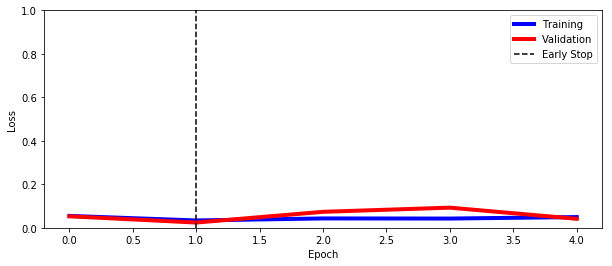

In [82]:
## Plot the learning curves for SPI1  
plot_learning_curve(history_case4_spi1)

In [83]:
#We  use a custom batch_predict function to generate predictions on the test set, one batch at a time 
case4_spi1_test_gen=DataGenerator("TF.test.hdf5",
                                   "hg19.genome.fa.gz",
                                     upsample=False,
                                     add_revcomp=False,
                                     batch_size=1000,
                                     tasks=['SPI1'])
case4_spi1_test_predictions=case4_spi1_model.predict_generator(case4_spi1_test_gen,max_queue_size=5000, workers=40, use_multiprocessing=True, verbose=1)


6046/6046 [==============================] - 354s 59ms/step


In [84]:

## Generate a ClassificationResult object to print performance metrics on held-out test set 
print(ClassificationResult(spi1_test_truth,case4_spi1_test_predictions))


Loss: 0.1153	Balanced Accuracy: 50.00%	 auROC: 0.486	 auPRC: 0.002
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 20189	 Num Negatives: 6025811


## Genome-wide interpretation of true positive predictions in SPI1, with DeepLIFT <a name='8'>
<a href=#outline>Home</a>

The highest test set auPRC was observed in Case 2 -- the single-tasked, genome-wide, SPI1 model with upsampling of positives. Let's run DeepLIFT on some high-confidence true positives. 


In [97]:
#get the true positive predictions with a threshold of 0.9 (i.e. high confidence true positive predictions)
true_pos_spi1=test_truth[spi1_test_truth*case2_spi1_test_predictions >0.9]
true_pos_spi1.head

<bound method NDFrame.head of                          SPI1   CTCF  ZNF143   SIX5
CHR   START    END                                 
chr2  191500   192500    True  False   False  False
      191550   192550    True  False   False  False
      191600   192600    True  False   False  False
      191650   192650    True  False   False  False
      215700   216700    True  False   False  False
      215750   216750    True  False   False  False
      215800   216800    True  False   False  False
      215850   216850    True  False   False  False
      257050   258050    True  False   False  False
      257100   258100    True  False   False  False
      257150   258150    True  False   False  False
      257200   258200    True  False   False  False
      268950   269950    True  False   False  False
      269000   270000    True  False   False  False
      269050   270050    True  False   False  False
      269100   270100    True  False   False  False
      275050   276050    True  Fal

In [98]:
true_pos_spi1.shape

(20189, 4)

In [100]:
from dragonn.utils import one_hot_from_bed
deep_lift_input_spi1=one_hot_from_bed([i for i in true_pos_spi1.index],"hg19.genome.fa.gz")
deep_lift_input_spi1.shape

In [ ]:
from dragonn.tutorial_utils import deeplift 

In [102]:
deep_lift_scores_spi1=deeplift(case2_spi1_model,deep_lift_input_spi1)

In [103]:
deep_lift_scores_spi1.shape

(20189, 1, 1000, 4)

Let's plot a few of the DeepLIFT tracks and see if the model successfully learned SPI1:

In [111]:
from dragonn.tutorial_utils import  plot_seq_importance

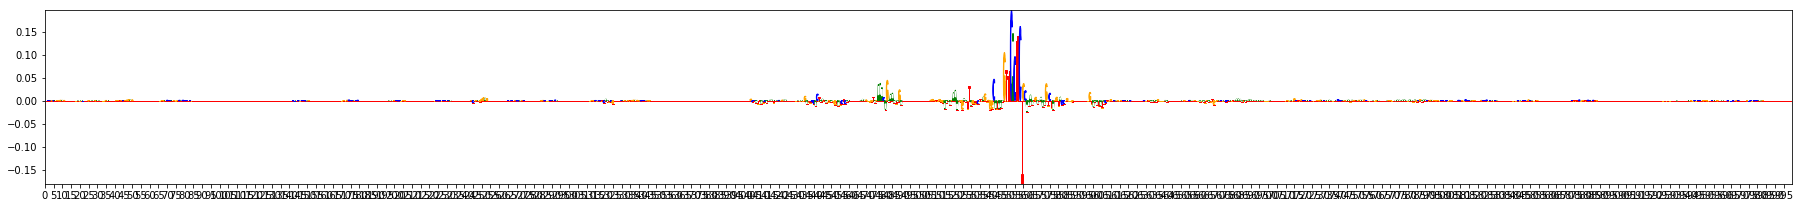

In [108]:
plot_seq_importance(deep_lift_scores_spi1[0],deep_lift_input_spi1[0])

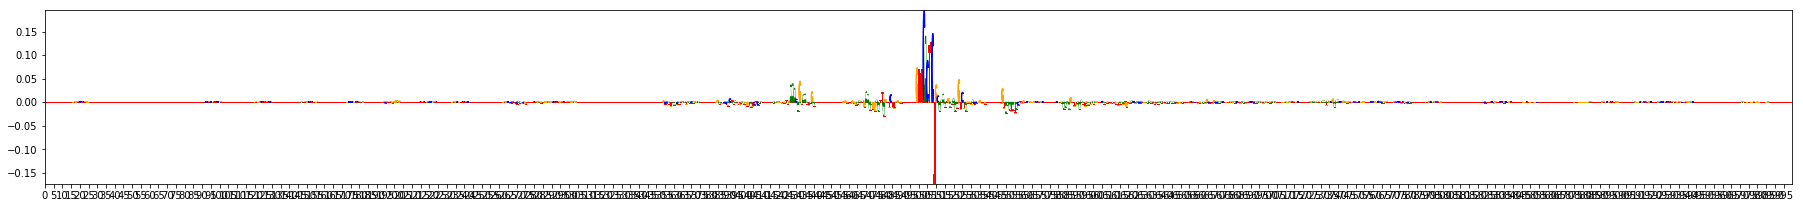

In [109]:
plot_seq_importance(deep_lift_scores_spi1[1],deep_lift_input_spi1[1])

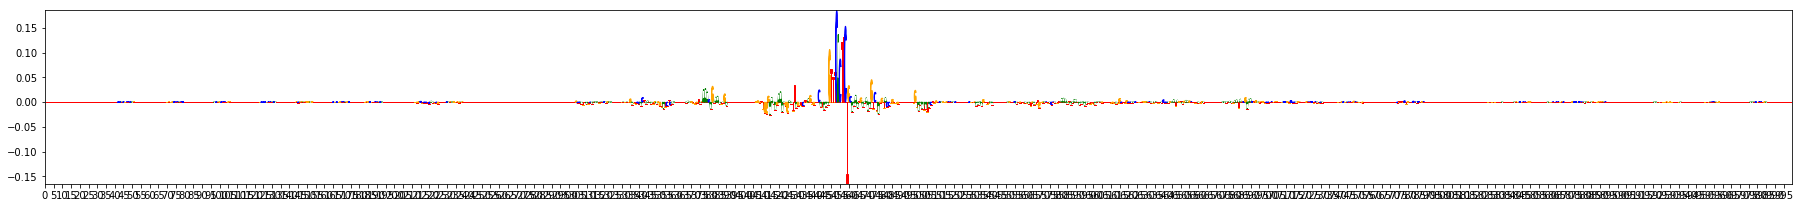

In [110]:
plot_seq_importance(deep_lift_scores_spi1[2],deep_lift_input[2])

Let's zoom in to the center of one sequence so that it is easier to distinguish the motif: 

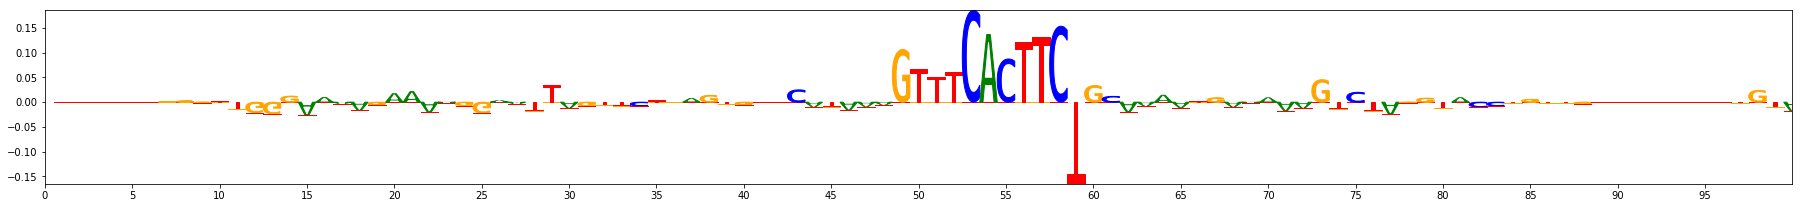

In [126]:
plot_seq_importance(deep_lift_scores[2].squeeze()[400:500],deep_lift_input[2].squeeze()[400:500])

If we query the sequence "GTTTCACTTC" in the [TomTom](http://meme-suite.org/tools/tomtom) software from the MEME suite, we find that the motif is a good match for IRF2, which is in the same motif family (Tryptophan cluster factors) as SPI1: 
<img src="tutorial_images/IRF.Tut4.png" alt="IRF2TomTom" width="400"/>


Let's interpret the high-confidence true positives from the CTCF model

In [ ]:
#get the true positive predictions with a threshold of 0.9 (i.e. high confidence predictions)
true_pos_ctcf=test_truth[ctcf_test_truth*case2_ctcf_test_predictions >0.9]
true_pos_ctcf.shape

In [127]:
deep_lift_input_ctcf=one_hot_from_bed([i for i in true_pos_ctcf.index],"hg19.genome.fa.gz")

In [128]:
deep_lift_scores_ctcf=deeplift(case2_ctcf_model,deep_lift_input_ctcf)

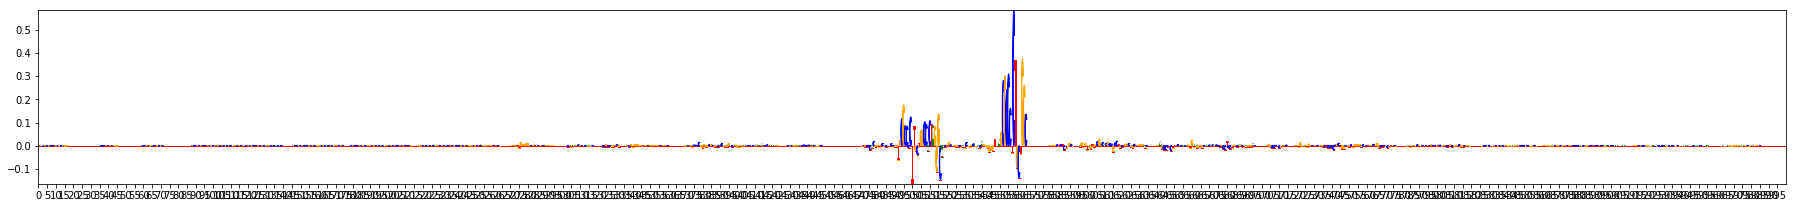

In [131]:
plot_seq_importance(deep_lift_scores_ctcf[0],deep_lift_input_ctcf[0])

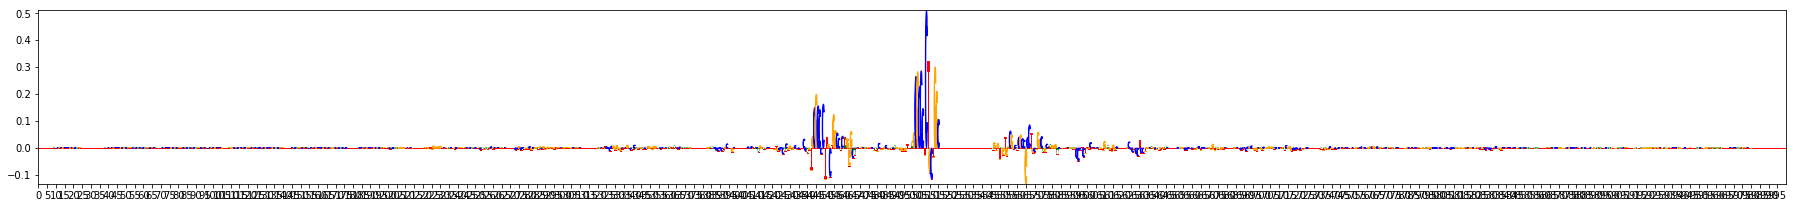

In [132]:
plot_seq_importance(deep_lift_scores_ctcf[1],deep_lift_input_ctcf[1])

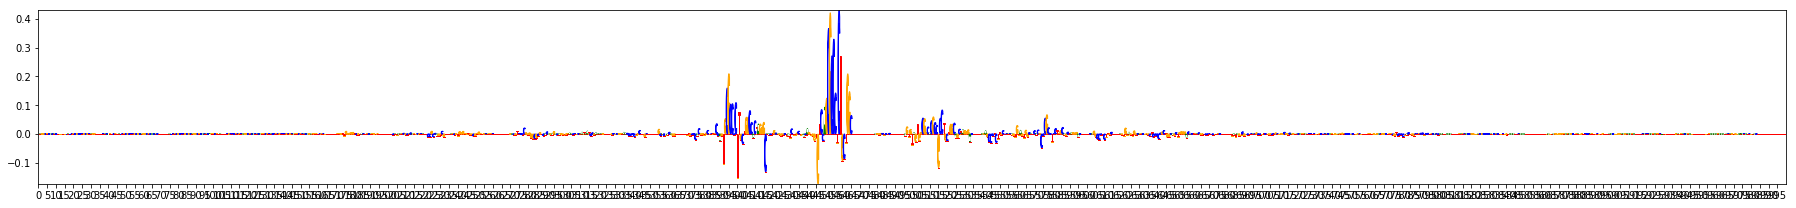

In [133]:
plot_seq_importance(deep_lift_scores_ctcf[2],deep_lift_input_ctcf[2])

Zooming in:

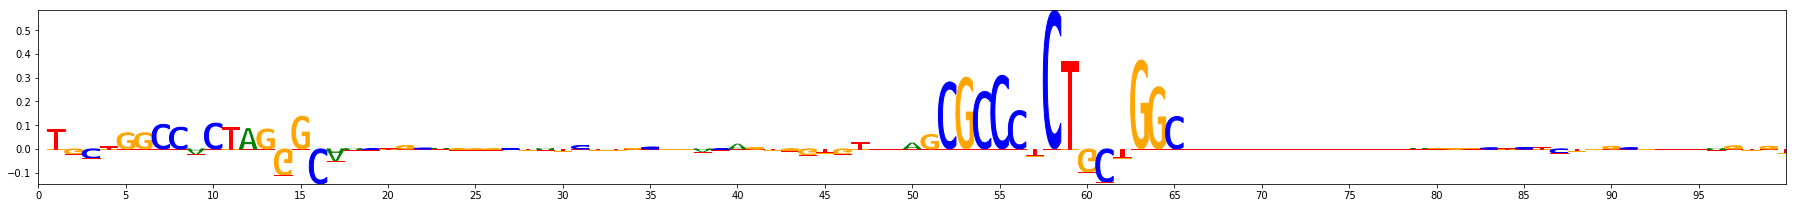

In [135]:
plot_seq_importance(deep_lift_scores_ctcf[0].squeeze()[500:600],deep_lift_input_ctcf[0].squeeze()[500:600])

Querying the sequence "CGCCCTCTGCTGGC" in TomTom confirms a strong match to the canonical CTCF motif:
<img src="tutorial_images/CTCF.Tut4.png" alt="CTCFTomTom" width="400"/>


## Conclusions <a name='9'>
<a href=#outline>Home</a>

From our analysis of *in vivo* transcription factor ChiP-seq datasets, we draw the following conclusions: 

* Training the models genome-wide by splitting the genome into short (200 bp), overlapping (stride=50) bins leads to improved generalization performance on the test set as compared to "easier" negative sets. I.E we observed superior test set performance for both the SPI1 and CTCF tasks when training on the whole genome as compared to using shuffled reference negatives. 


* Due to high class imbalance in *in vivo* data, it is necessary to upsample positive examples in each batch to facilitate model training. We found that upsampling positives to constitute 30% of each batch worked well --i.e. interpretation with DeepLIFT indicates the model learned the correct motif in CTCF and SPI1 ChIP-seq datasets. What happens if you alter the *upsample_ratio* parameter in the generator function? Does the model learn equally well with *upsample_ratio=0.1*? Does it learn better or worse with *upsample_ratio=0.5*? 


* Multi-tasking can lead to improved performance for tasks that are similar (i.e. CTCF/ZNF143/SIX5 are similar motifs). However, multi-tasking does not improve performance on tasks that are different (i.e. the SPI1 motif does not resemble the other three motifs, so multi-tasking does not improve performance for the SPI1 task). 


## Save tutorial outputs <a name='10'>
<a href=#outline>Home</a>

We save the models and test set predictions generated in this tutorial to an hdf5 file so that they can be loaded more readily in the future. 

In [139]:
#save the models 
case1_spi1_model.save("case1_spi1_model.hdf5")
case1_ctcf_model.save("case1_ctcf_model.hdf5")
case2_spi1_model.save("case2_spi1_model.hdf5")
case2_ctcf_model.save("case2_ctcf_model.hdf5")
case3_model.save("case3_model.hdf5")
case4_spi1_model.save("case4_spi1_model.hdf5")

In [158]:
#save the test set predictions 
import h5py 
test_set_predictions=h5py.File("test_set_predictions.hdf5",'w')
test_set_predictions.create_dataset("case1_spi1_test_predictions",data=case1_spi1_test_predictions)
test_set_predictions.create_dataset("case1_ctcf_test_predictions",data=case1_ctcf_test_predictions)
test_set_predictions.create_dataset("case2_spi1_test_predictions",data=case2_spi1_test_predictions)
test_set_predictions.create_dataset("case2_ctcf_test_predictions",data=case2_ctcf_test_predictions)
test_set_predictions.create_dataset("case3_test_predictions",data=case3_test_predictions)
test_set_predictions.create_dataset("case4_spi1_test_predictions",data=case4_spi1_test_predictions)
test_set_predictions.close() 